<center><img src="https://raw.githubusercontent.com/tquangsdh20/winedataset/master/.github/wine_logo.svg"></center>
<center><img src="https://img.shields.io/badge/Group5-Le%20Thai%20%7C%20Tran%20Quang%20%7C%20Le%20Thai%20Duy%20%7C%20Le%20Nhu%20Chien-blue?style=plastic"> <img src="https://img.shields.io/badge/Lecturer-Nguyen%20Hoang%20Dzung-orange?style=plastic"> <img src="https://img.shields.io/badge/version-4.0.5-blue?style=plastic&logo=R"></center>

## 1. Thu thập dữ liệu (Data Collection)
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Dữ liệu gồm có hai tập *datasets* về các mẫu rượu vang đỏ và trắng thu thập ở phía bắc của Bồ Đào Nha nhằm mô hình hóa chất lượng của rượu vang dựa trên các kiểm nghiệm hóa lý. Tập dữ liệu nghiêm cứu được lấy từ [UC Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) có thể tải về [tại đây](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/).

### 1.1. Mô tả dữ liệu
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Hai bộ dữ liệu trên liên quan đến các biến thể về rượu vang trắng và đỏ ở Bồ Đào Nha, tập dữ liệu về rượu vang trắng gồm có 4898 bản ghi (individuals) và rượu vang đỏ có 1599 bản ghi (individuals). Trong đó, dữ liệu phân tích gồm có 12 biến dữ liệu, trong đó có 11 biến là các thông số thành phần hóa lý và 1 biến đánh giá chất lượng.

### 1.2. Đặt vấn đề
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Bài toán được đặt ra trong nghiên cứu này liệu có thể tiên lượng được chất lượng của loại rượu dựa trên các thành phần hóa lý của nó hay không? Và màu sắc của rượu có phụ thuộc vào các thành phần hóa lý trên hay không?

## 2. Trình bày dữ liệu

Dữ liệu trong hai tập trên gồm 12 biến như sau:

- **fixed.acidity**: thông số đo độ chua cố định
- **volatile.acidity**: mức độ bay hơi của rượu
- **citric.acid**: nồng độ Axit Citric
- **residual.sugar**: lượng đường
- **chlorides**: nồng độ Clo
- **free.sulfur.dioxide**: các thành phần $SO_2$ tự do
- **total.sulfur.dioxide**: tổng số gốc $SO_2$
- **density**: mức độ đậm đặc của rượu
- **pH**: nồng độ pH
- **sulphates**: các gốc $SO_4$
- **alcohol**: nồng độ cồn
- **quality**: kết quả chất lượng được đánh giá theo thang điểm từ 1-10


Đọc hai tập dữ liệu vào và tiến hành các bước tiền xử lý

In [29]:
require(dplyr)
require(ggplot2)
require(rpart)
require(caTools)
require(caret)
require(rpart.plot)
require(FactoMineR)
require(PerformanceAnalytics)

In [2]:
set.seed(1)
red_wine = read.csv('winequality-red.csv',sep = ';')
white_wine = read.csv('winequality-white.csv',sep = ';')
white_wine = white_wine %>% sample_frac(0.3264)

Ghép hai tập dữ liệu lại và thêm một biến **type** để gắn nhãn cho các loại phân tích (*white và red*)

In [3]:
wine_dat <- rbind(
    data.frame(white_wine,type='white')
    ,data.frame(red_wine,type='red')
)
wine_dat$type <- as.factor(wine_dat$type)

## 3. Phân tích và giải thích dữ liệu

Trước khi chọn phương pháp phân tích ta kiểm tra lại phân bố về chất lượng của loại rượu được phân bố như thế nào

### 3.1. Biểu diễn phân bố chất lượng của rượu

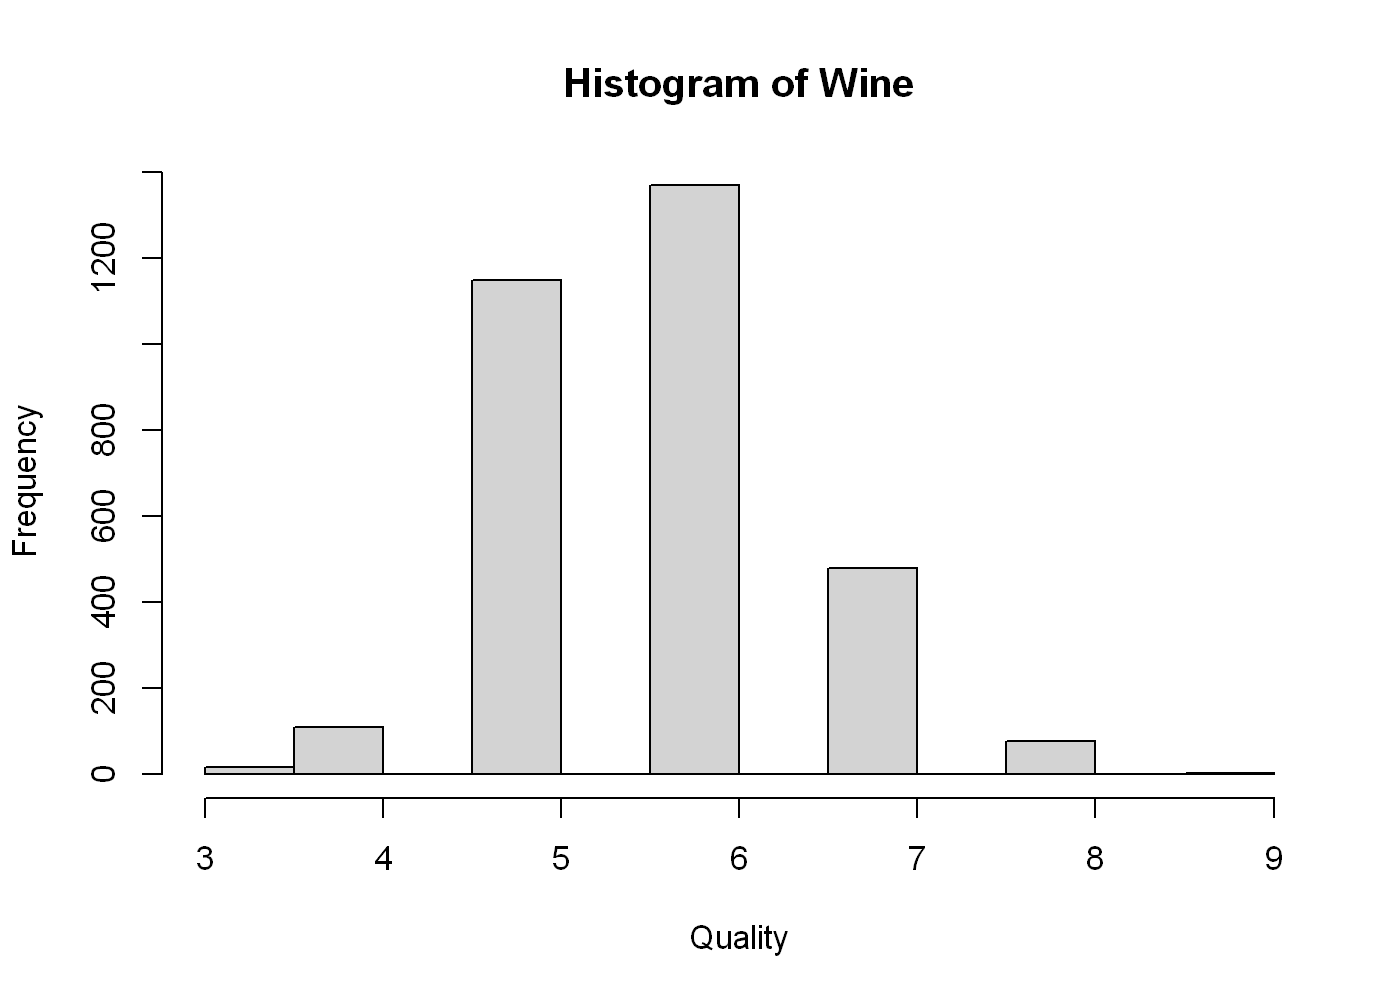

In [4]:
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 200)
hist(wine_dat$quality,xlab='Quality',main='Histogram of Wine')

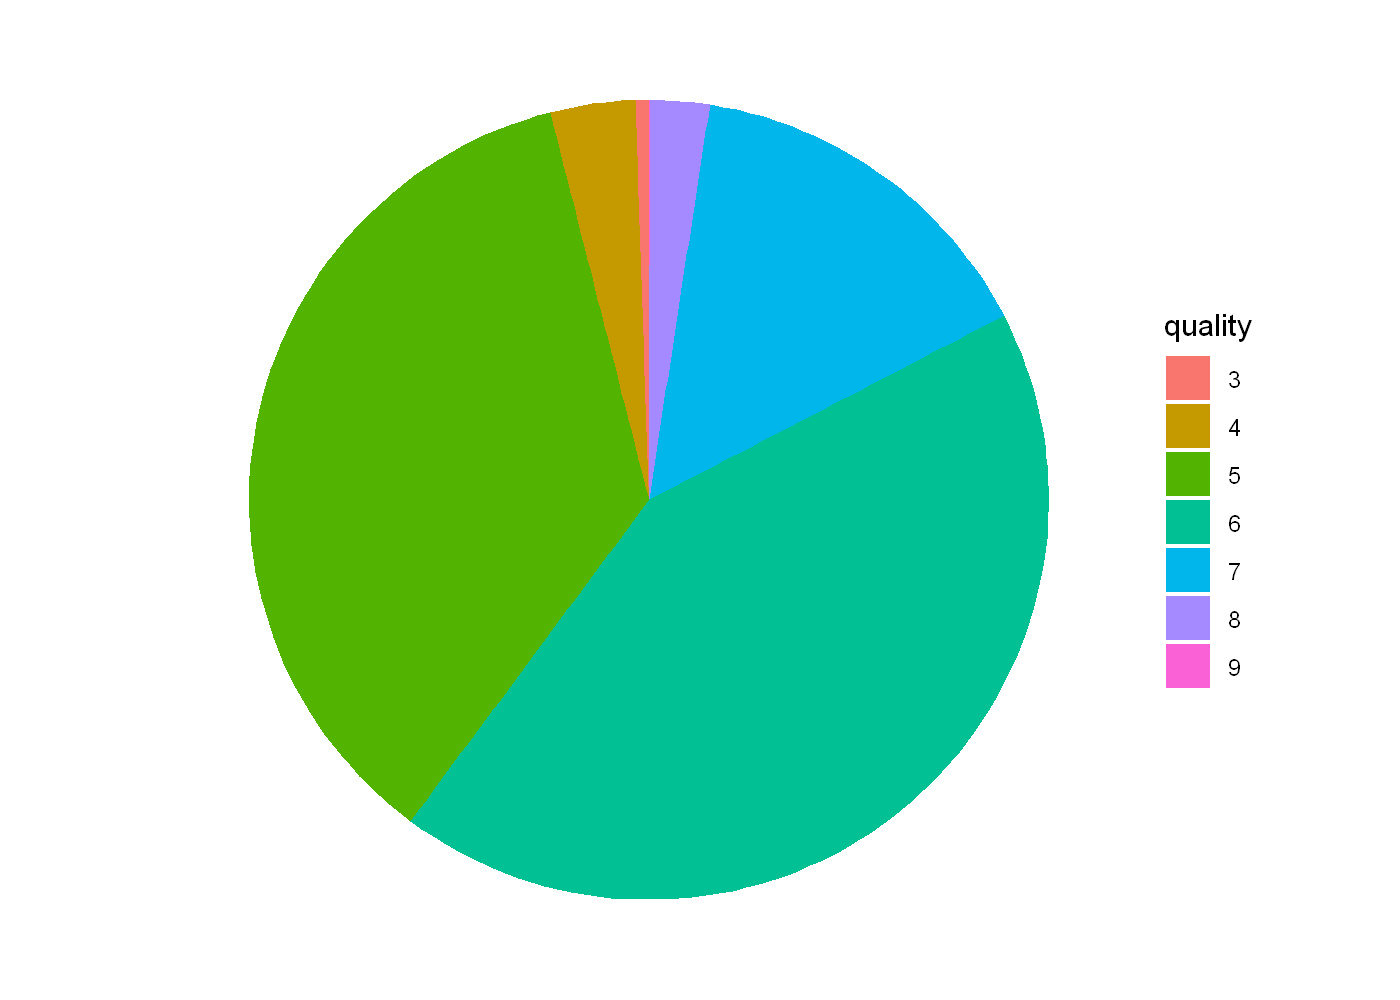

In [5]:
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 200)
pie_dat = data.frame(value=c(17,110,1147,1368,478,76,2),quality=as.factor(3:9))
ggplot(pie_dat, aes(x = "", y = value, fill = quality)) +
  geom_bar(width = 1, stat = "identity") +
  coord_polar("y", start=0) +theme_void()

Từ biểu đồ phân bố về chất lượng của rượu được đánh giá từ 3 đến 9 trên thang điểm 10. Tuy nhiên, thang điểm 5 và 6 chiếm nhiều nhất. Ít nhất là điểm 9 chỉ có 2 loại rượu được đánh giá là 9.

### 3.2. Quan hệ giữa các biến với nhau

Dưới đây là biểu đồ biểu diễn ma trận tương quan giữa các biến dữ liệu trong tập dữ liệu phân tích

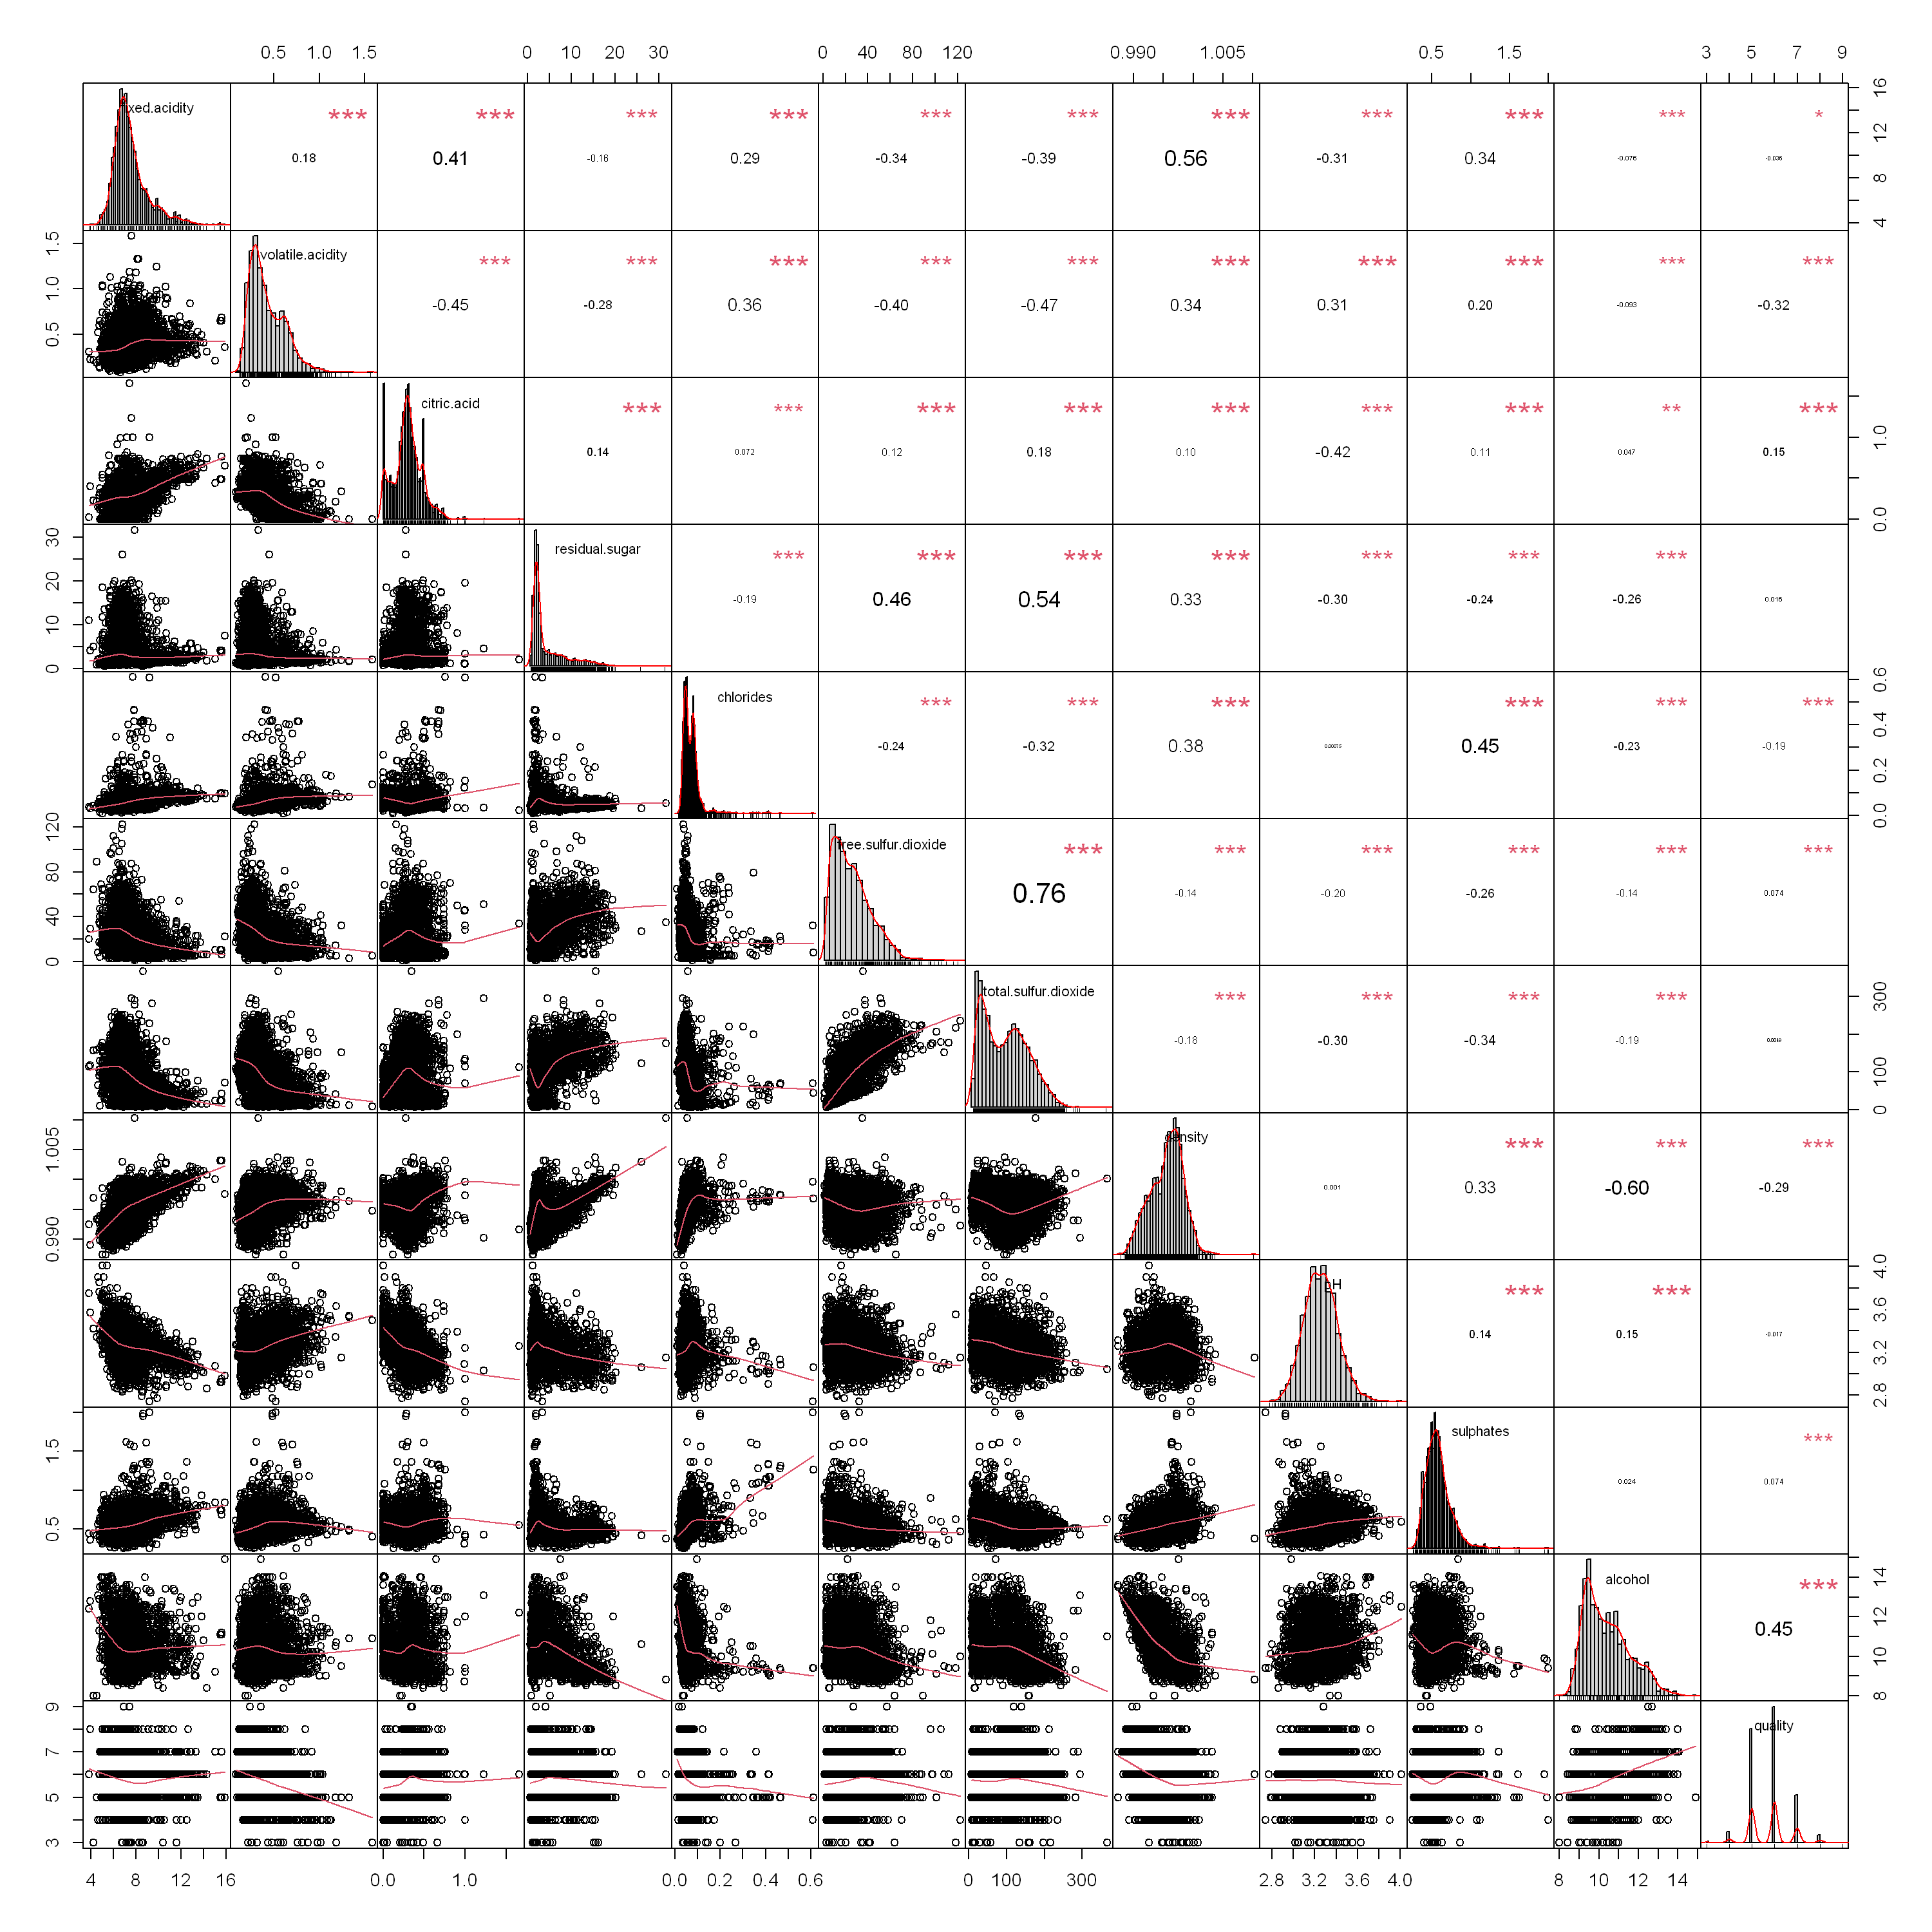

In [6]:
options(repr.plot.width = 12, repr.plot.height = 12, repr.plot.res = 250)
chart.Correlation(wine_dat[,1:12],histogram=TRUE,pch="+")

<p>Biểu đồ trên cho thấy một số biến có ảnh hưởng đến nhau như sau:

<div align="justify">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Độ chua cố định của rượu <i>(fixed.acidity)</i> bị ảnh hưởng bởi các yếu tố mức độ bay hơi <i>(volatile.acidity)</i>, nồng độ Clo <i>(chlorides)</i>, nồng độ các gốc $SO_4$ <i>(sulphates)</i>, nồng độ axit citric trong rượu <i>(citric.acid)</i> và mức độ đậm đặc của rượu <i>(density)</i> với mức độ ảnh hưởng tăng dần theo tương quan thuận. Trong đó, hai thông số có ảnh hưởng lớn nhất đến độ chua là mức độ đậm đặc của rượu và nồng độ axit citric trong rượu với hệ số tương quan lần lượt là <i>0.56 và 0.41</i>, theo kết quả cho thấy sự khác biệt về độ chua của rượu trong dữ liệu có thể giải thích được <i>16.81%</i> dựa trên sự khác biệt về nồng độ axit citrid của các loại rượu và <i>31.36%</i> dựa trên sự khác biệt về nồng độ. Ngoài ra, độ chua cố định có tương quan nghịch với nồng độ $SO_2$ tự do <i>(free sulfur dioxide)</i>, nồng độ tổng số gốc $SO_2$ <i>(total sulfur dioxide)</i>, độ PH <i>(PH)</i>, với hệ số tương quan nằm trong khoảng <i>[-0.39,-0.31]</i> </div>
</p>
<p>
<div align="justify">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Độ bay hơi của rượu <i>(volatile.acidity)</i> bị ảnh hưởng bởi nồng độ Clo <i>(chlorides)</i>, độ đậm đặc <i>(density)</i> và độ PH của rượu với mức độ ảnh hưởng tăng dần theo tương quan thuận. Trong đó, hệ số tương quan giữa độ bay hơi của rượu với các yếu tố trên gần tương tự nhau, trong khoảng <i>[0.31,0.36]</i>. Ngược lại, độ bay hơi của rượu có tương quan nghịch với nồng độ axit citric <i>(citric.acid)</i> nồng độ $SO_2$ tự do <i>(free sulfur dioxide)</i>, nồng độ tổng số gốc $SO_2$ <i>(total sulfur dioxide)</i>, với hệ số tương quan nằm trong khoảng <i>[-0.47,-0.4]</i></div>
</p>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Độ đậm đặc của rượu <i>(density)<i/> có tương quan thuận với nồng độ gốc $SO_4$ <i>(sulphates)</i>, lượng đường <i>(residual sugar)</i> và nồng độ Clo <i>(chlorides)</i>, với hệ số tương quan trong khoảng <i>[0.33,0.38]</i>. Ngược lại, độ đậm đặc của rượu tương quan nghịch với nồng độ cồn <i>(alcohol)</i> với hệ số tương quan -0.6.

<p>
<div align="justify">&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Chất lượng rượu <i>(quality)</i> có tương quan thuận với nồng độ cồn và nồng độ Axit Citric <i>(citric.acid)</i> với hệ số tương quan lần lượt là 0.45 và 0.15. Ngược lại, chất lượng rượu có tuongq quan nghịch với độ đậm đặc <i>(density)</i> và độ bay hơi của rượu <i>(volatile.acidity)</i> với hệ số tương quan lần lượt là -0.39 và -0.32.</div>
</p>
<p>
<div align="justify">Đó là tất cả những tương quan ta có thể thấy được, tuy nhiên ngoài ra dữ liệu còn có thể có những tương quan tiềm ẩn mà ta chưa thể khám phá ra được. Để khai thác các yếu tố tiềm ẩn giữa chất lượng của rượu cũng như là cách thức phân loại rượu dựa trên các yếu tố hóa lý.</div>
</p> 

### 3.3. Phân tích thành phần chính (PCA)

In [113]:
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 200)
res.pca <- PCA(wine_dat
               ,quanti.sup=12
               ,quali.sup=13
              ,scale.unit=TRUE
              ,ncp=11)
round(res.pca$eig,2)

,eigenvalue,percentage of variance,cumulative percentage of variance
comp 1,3.34,30.40,30.40
comp 2,2.36,21.43,51.83
comp 3,1.64,14.93,66.75
comp 4,0.92,8.37,75.12
comp 5,0.74,6.70,81.83
comp 6,0.57,5.15,86.97
comp 7,0.48,4.35,91.32
comp 8,0.45,4.13,95.45
comp 9,0.28,2.55,98.00
comp 10,0.18,1.64,99.64


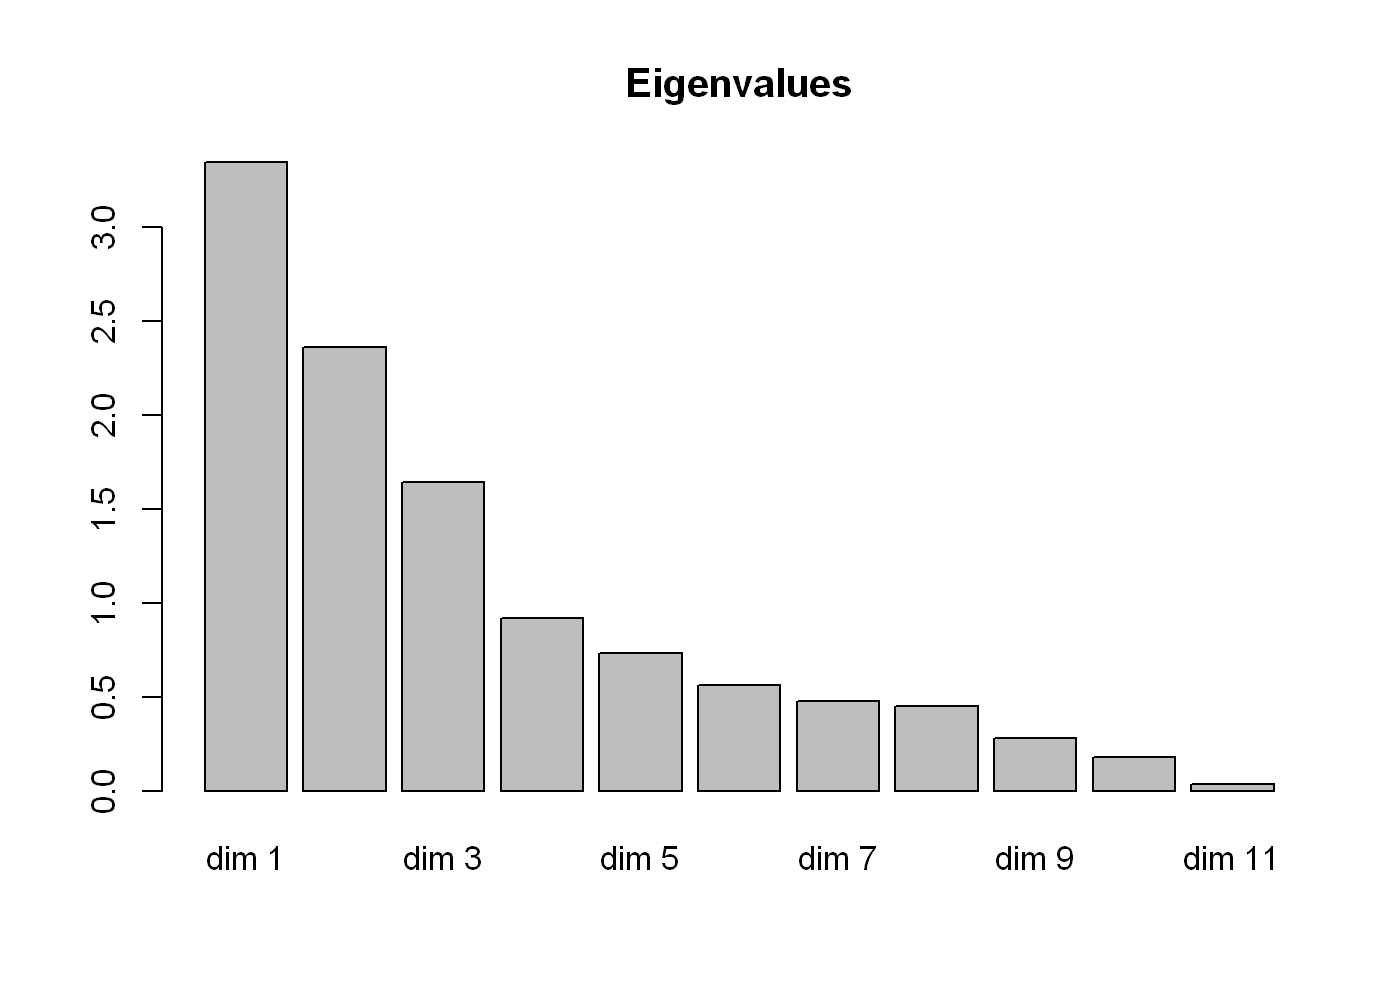

In [114]:
options(repr.plot.width = 7, repr.plot.height = 5, repr.plot.res = 200)
barplot(res.pca$eig[,1],main="Eigenvalues",
names.arg=paste("dim",1:nrow(res.pca$eig)))

Kết quả cho thấy hai chiều không gian chính Dim1 và Dim2 có thể giải thích được 51.83% các giao động của dữ liệu chưa bao gồm các biến giải thích *quality* và *type*, tỉ lệ giải thích là tương đối thấp tuy nhiên nó có thể diễn giải được cấu trúc cần thiết của dữ liệu, vì phân tích PCA trên gồm có 11 biến dữ liệu và lượng mẫu tương đối rất lớn gần 3200 mẫu thì tỉ lệ giải thích được cần thiết là trên 28.9% (Dựa trên kết quả so sánh với khoảng tin cậy 95% của kết quả chạy 10000 các phân tích PCAs). Tuy nhiên sự biến đổi của các yếu tố lý hóa tác động đến chất lượng của rượu không thể chỉ giải thích được dữa trên hai chiều không gian chính.

In [11]:
res.pca$quanti.sup

,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,Dim.10,Dim.11
quality,-0.1588748,-0.1659027,-0.3776203,0.1430706,0.2174304,0.1290708,-0.05572945,-0.07379236,-0.1589965,-0.008851132,0.03467706
,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,Dim.10,Dim.11
quality,-0.1588748,-0.1659027,-0.3776203,0.1430706,0.2174304,0.1290708,-0.05572945,-0.07379236,-0.1589965,-0.008851132,0.03467706
,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,Dim.10,Dim.11
quality,0.0252412,0.0275237,0.1425971,0.02046921,0.047276,0.01665927,0.003105771,0.005445313,0.02527988,7.834254e-05,0.001202498


<p><div align="justify">Qua kết quả đánh giá biến giải thích đối với các chiều không gian cho thấy rằng chất lượng của rượu nó đóng góp tốt nhất ở chiều không gian thứ 3. Tiếp đến là chiều không gian Dim5, Dim2, Dim9, Dim1... Nên ta sẽ chọn chiều không gian Dim1 và Dim3 này để biểu diễn theo biến chất lượng của rượu để phân tích vì nó tốt nhất và mức độ ý nghĩa giải thích các giao động của dữ liệu là cao nhất.</div></p>

#### Biểu diễn chiều Dim1 và Dim3 để xem xét chất lượng của rượu

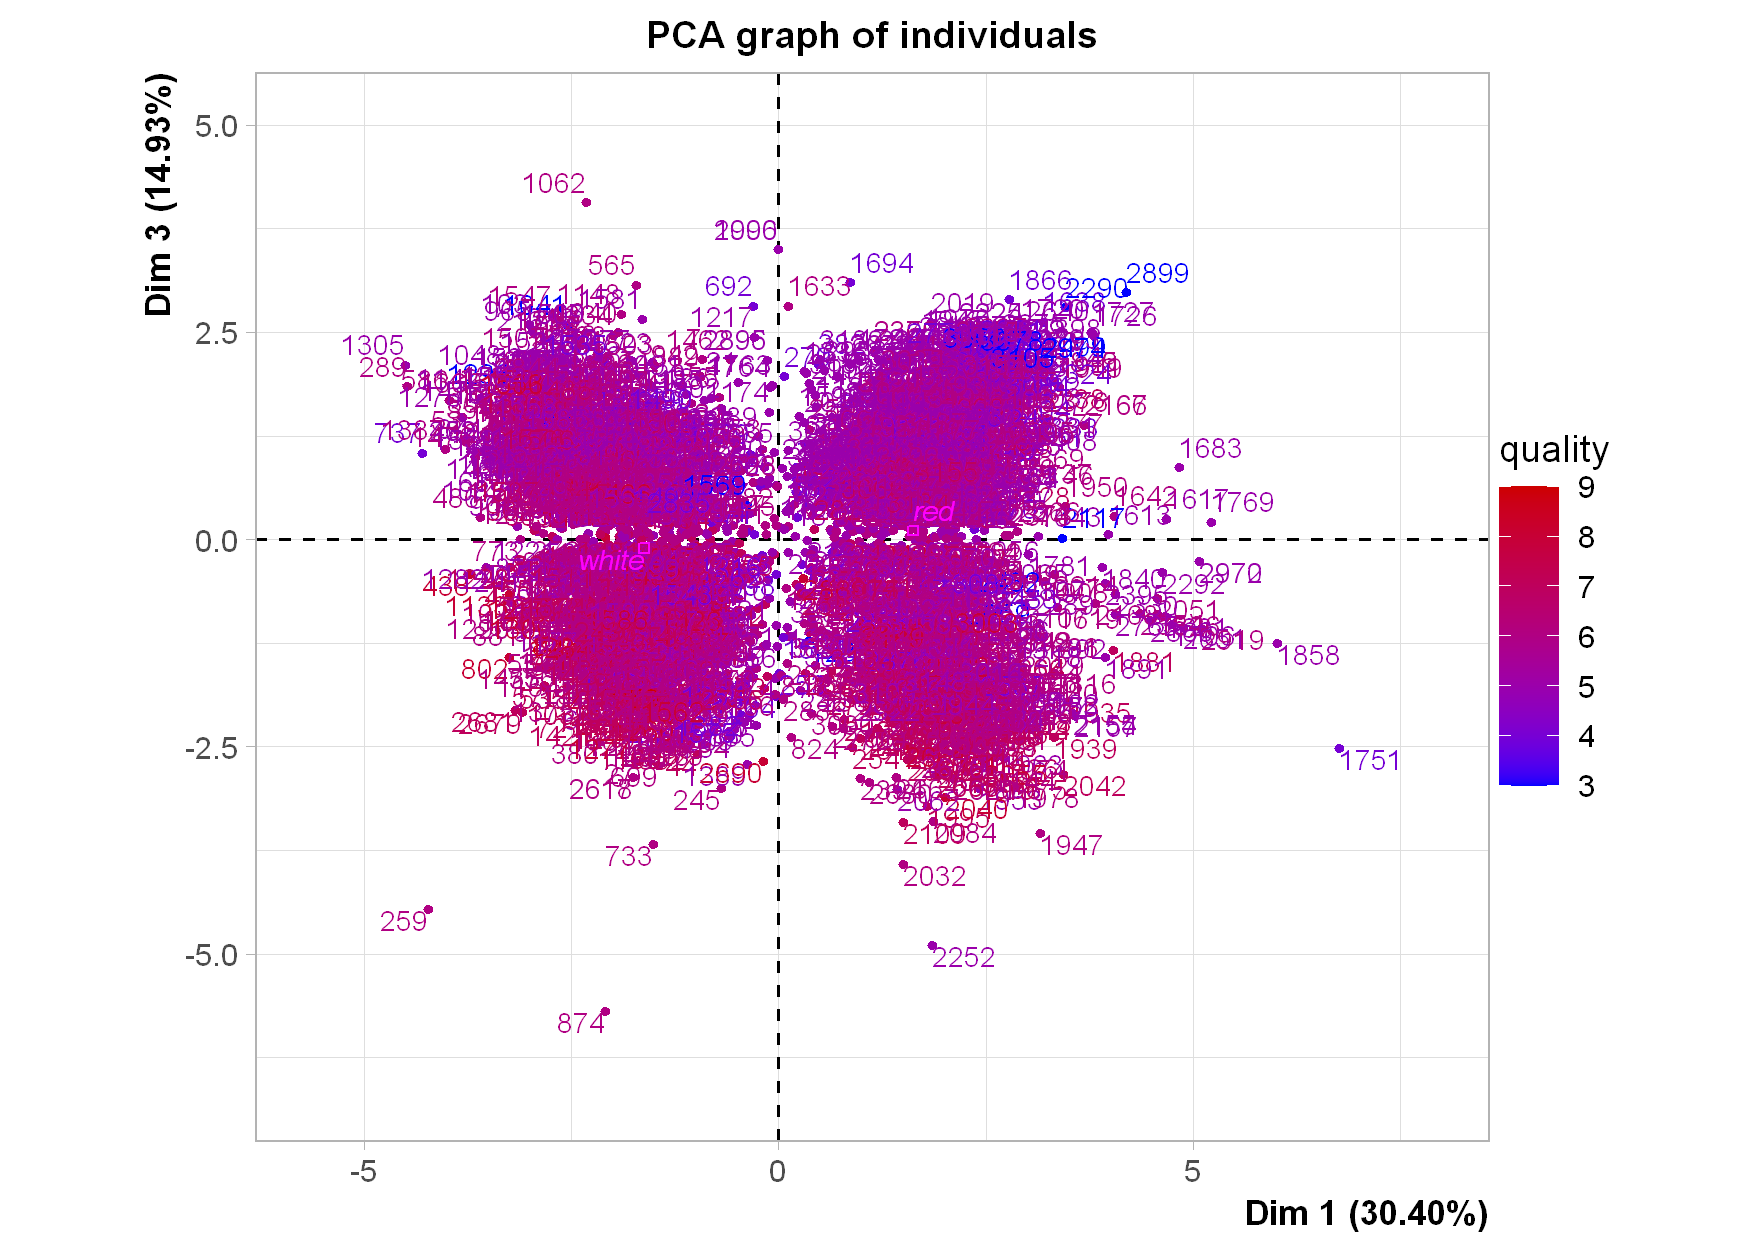

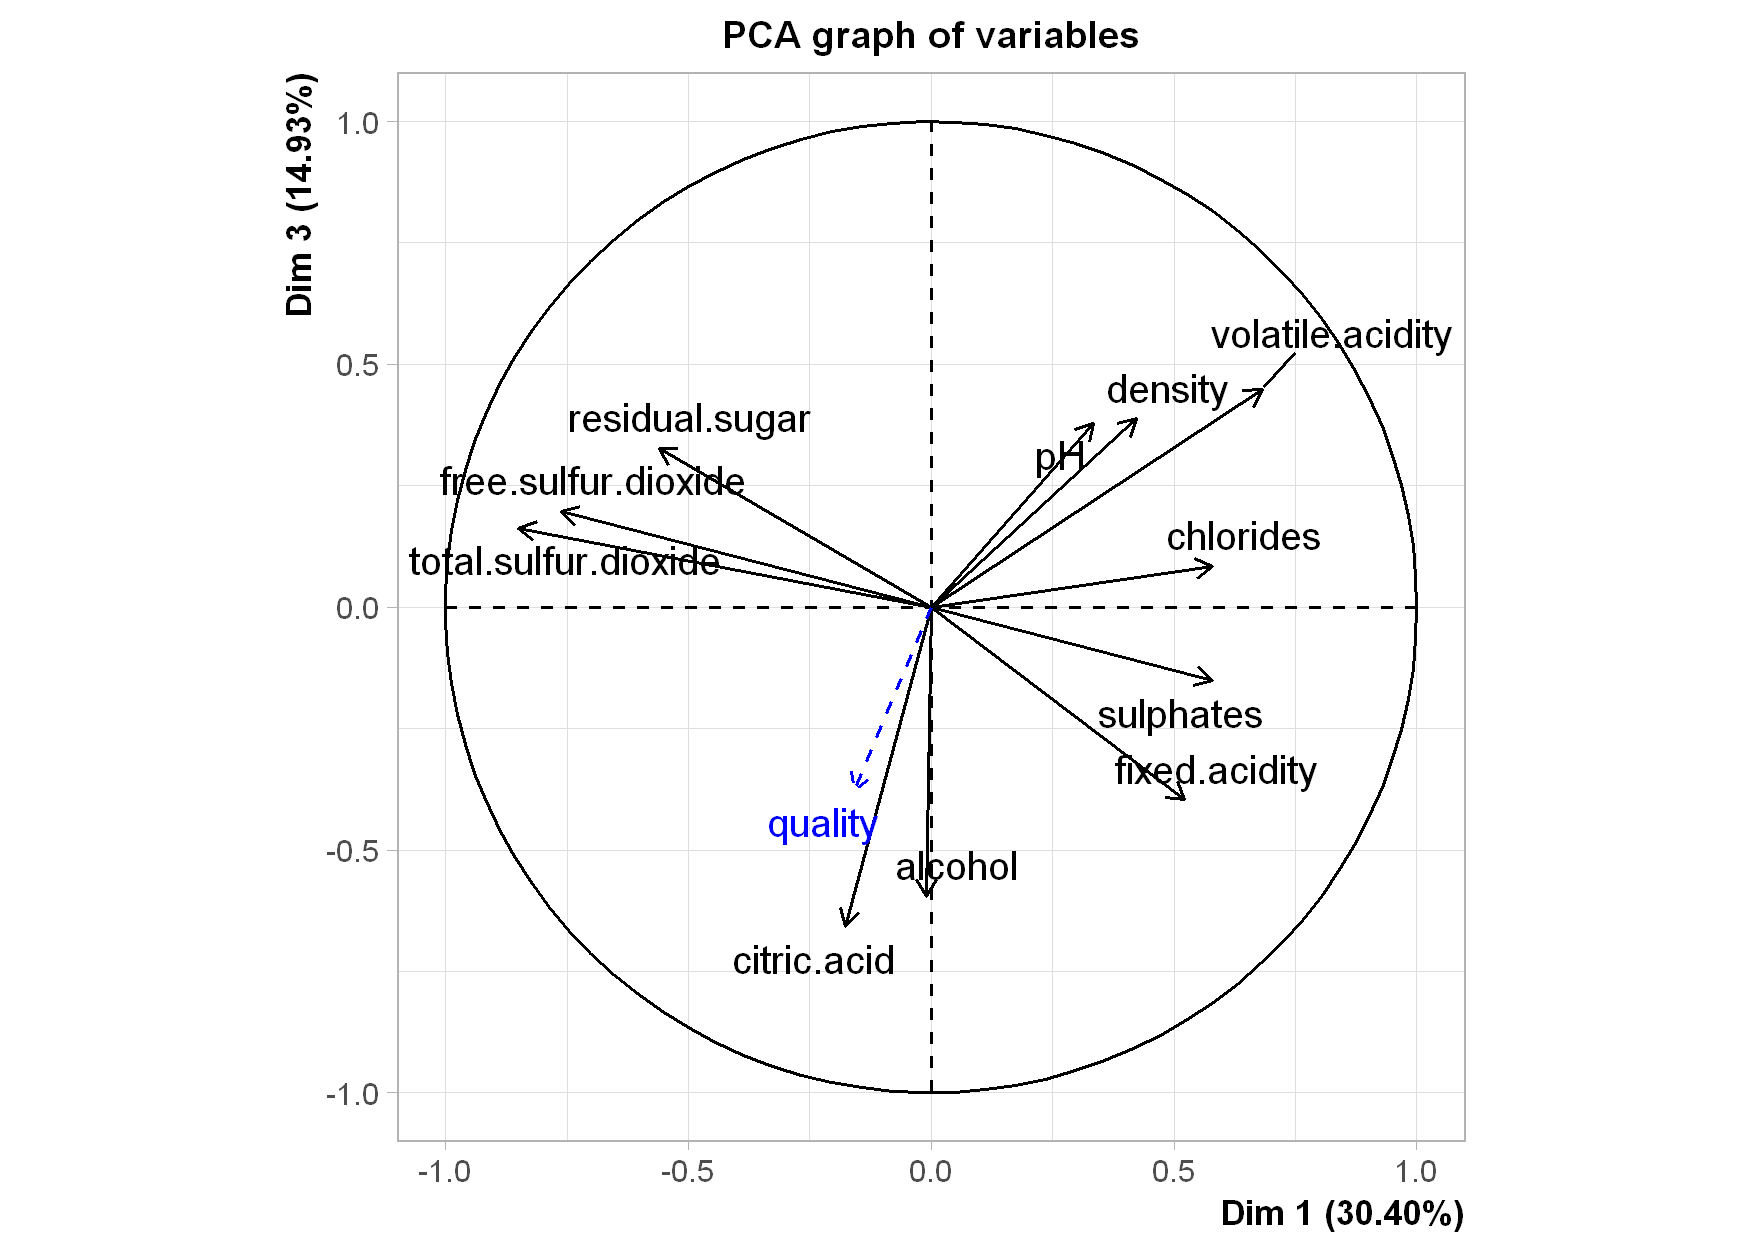

In [12]:
options(repr.plot.width = 7, rep.plot.height = 7, repr.plot.res = 250)
plot(res.pca,choix="ind",habillage=12,cex=0.7,axes=c(1,3))
plot(res.pca,choix="var",axes=c(1,3))

<p><div align="justify">
Nhận xét về các cá thể ta thấy rằng cấu trúc đám mây dữ liệu trong hai chiều này phân chia ra thành cụm chính rõ ràng theo 4 góc phần tư, như hình bốn cánh hoa, ngoài ra ta thấy rằng các điểm dữ liệu vùng biên, hay vùng ngoại lai đa phần là các điểm dữ liệu màu xanh dương hoặc xanh tím, là mức chất lượng thấp nhất trong tập dữ liệu khoảng 3 ~ 4 điểm. Mức độ chất lượng của sản phẩm rượu cũng tăng dần vào tâm của mỗi cánh hoa vì càng vào tâm các cánh hoa ta thấy rằng màu sắc nó chuyển từ tím sáng đỏ và đậm dần, điều này chứng tỏ mức độ điểm chất lượng tăng dần.  
</div></p>
<p><div align="justify">
Ngoài ra, ta có thể thấy được rằng chất lượng rượu nó tương quan rất tốt đối với các yếu tố, nồng độ cồn, thành phần axit citric, các gốc sulphat, điều này cho thấy chất lượng của rượu có thể tăng thêm nếu các yếu tố này tốt. Tuy nhiên, cũng có những yếu tố khác ảnh hưởng tiêu cực đến chất lượng của rượu như là mức độ bay hơi của rượu, nồng độ clo, độ đậm đặc của rượu. Ngoài ra, theo như ta thấy thì yếu tố chất lượng của rượu gần như trực giao với các yếu tố nồng độ $SO_4$ và lượng đường dư trong rượu, tức là các yếu tố này không ảnh hưởng đến chất lượng của rượu.
</div></p>
<p><div align="justify">
Tuy nhiên, mức độ ý nghĩa của cả hai chiều này chỉ chiểm khoảng 45.33%, tỉ lệ tương đối thấp. Tuy nhiên vẫn diễn tả được mức cần thiết của cấu trúc dữ liệu. Hay nói cách khác nếu chỉ dựa vào các phân tích thành phần chính trong hai chiều không gian đầu tiên thì không đủ để giải thích được ý nghĩa của các giao động về chất lượng rượu vì đóng góp của quality trên các chiều không gian chính là không nhiều như đã đề cập trước đó. Để giải thích được tốt nhất chất lượng của sản phẩm rượu, cần phải phối hợp thêm các chiều không gian khác để giải thích trong trường hợp này ta sẽ chọn các chiều không gian Dim1, Dim2, Dim3, Dim4, Dim5, Dim6 và Dim9 để giảm bớt các chiều không gian để tiến hành ứng dụng các model máy học phân tích và dự đoán chất lượng của rượu vang, khi đó khả năng giải thích cho các giao động dữ liệu trong trường hợp này tổng cộng là 89.52%.</div></p>
<p>
<div align="justify"></div>    
</p>

In [13]:
res.pca$quali.sup

,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,Dim.10,Dim.11
red,1.623442,0.0494572,0.1039025,-0.003756273,0.07915237,0.02133134,0.06223171,0.05619791,-0.05000114,-0.05043631,-0.0360665
white,-1.623442,-0.0494572,-0.1039025,0.003756273,-0.07915237,-0.02133134,-0.06223171,-0.05619791,0.05000114,0.05043631,0.0360665
,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,Dim.10,Dim.11
red,0.9875037,0.0009164822,0.004044986,5.286633e-06,0.002347431,0.0001704909,0.00145107,0.001183328,0.0009367524,0.0009531287,0.0004873859
white,0.9875037,0.0009164822,0.004044986,5.286633e-06,0.002347431,0.0001704909,0.00145107,0.001183328,0.0009367524,0.0009531287,0.0004873859
,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,Dim.10,Dim.11
red,50.19962,1.821258,4.584977,-0.2213375,5.212995,1.602719,5.088093,4.714618,-5.338979,-6.710539,-10.27119
white,-50.19962,-1.821258,-4.584977,0.2213375,-5.212995,-1.602719,-5.088093,-4.714618,5.338979,6.710539,10.27119
,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.7,Dim.8,Dim.9,Dim.10,Dim.11
type,0.7882397,0.001037529,0.006575544,1.532383e-05,0.008500255,0.0008034745,0.008097806,0.006952651,0.008916077,0.0140855,0.03299883


Từ kết quả biểu diễn đóng góp của biến giải thích phân loại rượu ta thấy đóng góp rất tốt trong chiều không gian Dim1, và hệ số cos2 của biến gần bằng 1 trong chiều không gian này. Ta biểu diễn nó trên hai chiều không gian chính để quan sát sự phân chia dữ liệu theo biến giải thích phân loại này.

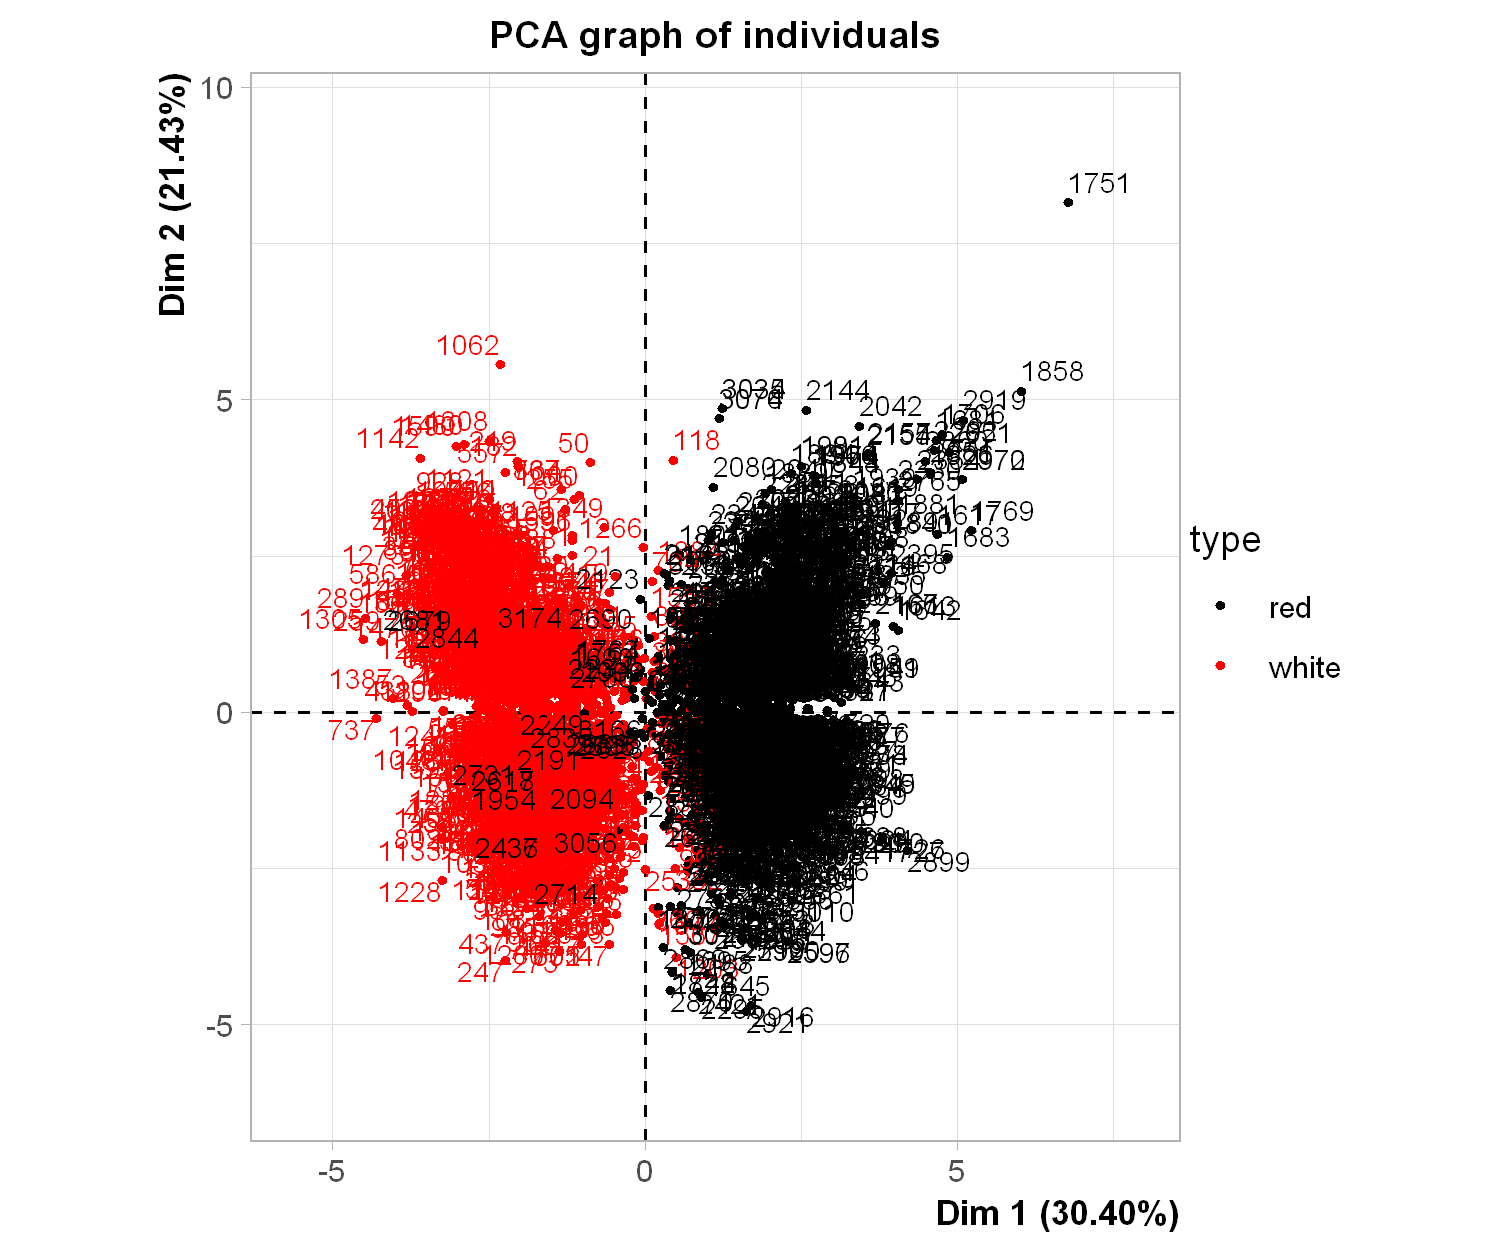

In [14]:
options(repr.plot.width = 6, rep.plot.height = 5, repr.plot.res = 250)
plot(res.pca,choix="ind",habillage=13,cex=0.7)

Khi biểu diễn dữ liệu theo biến giải thích về phân loại, ta thấy được rõ ràng dữ liệu tách hẳn ra thành 2 cụm dữ liệu riêng biệt trong chiều không gian chính thứ nhất. Hay nói cách khác chiều không gian chính thứ nhất là chiều không gian để phân chia loại rượu.

## 4. Xây dựng hai model máy học dự đoán chất lượng rượu và dự đoán loại rượu

Ở phần này nhóm thực hiện sẽ ứng dụng kiến thức chuyên môn để xây dựng hai mô hình máy học theo quy trình bên dưới:
- Mô hình dự đoán chất lượng của rượu dựa trên các thành phần chính đã phân tích trước đó
- Mô hình dự đoán chất lượng của rượu dựa trên 2 các thành phần chính 

<center><img src="https://raw.githubusercontent.com/tquangsdh20/winedataset/master/.github/model.svg"></center>

### 4.1. Xây dựng mô hình máy học dự đoán chất lượng của loại rượu

Phần này ta sẽ phân nhóm các chất lượng loại rượu làm 3 nhóm chính sau đây:
- **low** : Những nhóm chất lượng rượu từ 1 ~ 4
- **medium** : Nhóm những loại rượu chất lượng từ 5 ~ 6
- **high** : Nhóm những loại rượu chất lượng từ 7 ~ 9  

In [169]:
quality_dat = data.frame(cbind(res.pca$ind$coord[,c(1:6,9)],quality=wine_dat$quality))
quality_dat[quality_dat$quality < 5.0,'quality'] <- 'low'
quality_dat[quality_dat$quality < 7.0,'quality'] <-  'medium'
quality_dat[(quality_dat$quality != 'low')&(quality_dat$quality != 'medium'),'quality'] <- 'high'
quality_dat$quality <- as.factor(quality_dat$quality)
head(quality_dat)
set.seed(1)
dat_smpl = sample.split(quality_dat$quality,SplitRat=0.8)
train_dat = data.frame(subset(quality_dat,dat_smpl == T))
test_dat = data.frame(subset(quality_dat,dat_smpl == F))
summary(train_dat$quality)

,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,Dim.6,Dim.9,quality
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,-1.1583155,2.50205297,0.2217197,1.26054836,0.03139377,0.7256396,0.83457751,medium
2,-0.8394453,-1.23367395,-1.4868028,-0.59027497,-0.70410815,-0.4750232,0.63519386,low
3,-0.8165065,-0.02031042,1.2824748,-1.41618571,-0.03556543,-0.6553109,0.03552704,medium
4,-3.3597111,0.70299773,-0.5510811,0.01412896,-0.26905030,0.4585865,-0.25063590,high
5,-2.1528084,0.60018393,-0.5024772,-0.64938786,0.48874428,2.0472824,-0.35180532,medium
6,-2.8004525,2.84244601,0.3240747,-0.16091926,0.27056494,-0.3612317,0.44328676,low


high    low medium 
   445    102   2012

Khi đó, ta thấy kết quả bảng dữ liệu mới biểu diễn như ở trên. Tuy nhiên, phân bố giữa các nhóm là không được đồng đều do đó ta cần phải lấy mẫu gia tăng để giải quyết việc mất cân bằng của tập dữ liệu. Sau đó, tiến hành phân tích xây dựng model máy học theo mô hình cây học quyết định *(Decision Tree)*.

In [170]:
subdat0 = subset(quality_dat,quality_dat$quality=='low')
subdat0 = rbind(subdat0,subdat0,subdat0)
subdat1 = subset(quality_dat,quality_dat$quality=='high')
train_dat = rbind(train_dat,subdat0,subdat0,subdat0,subdat1)
summary(train_dat$quality)

high    low medium 
  1001   1245   2012

ERROR: Error in legend(x = x, y = y, legend = legend, col = 0, xpd = NA, bty = "n", : argument 8 matches multiple formal arguments


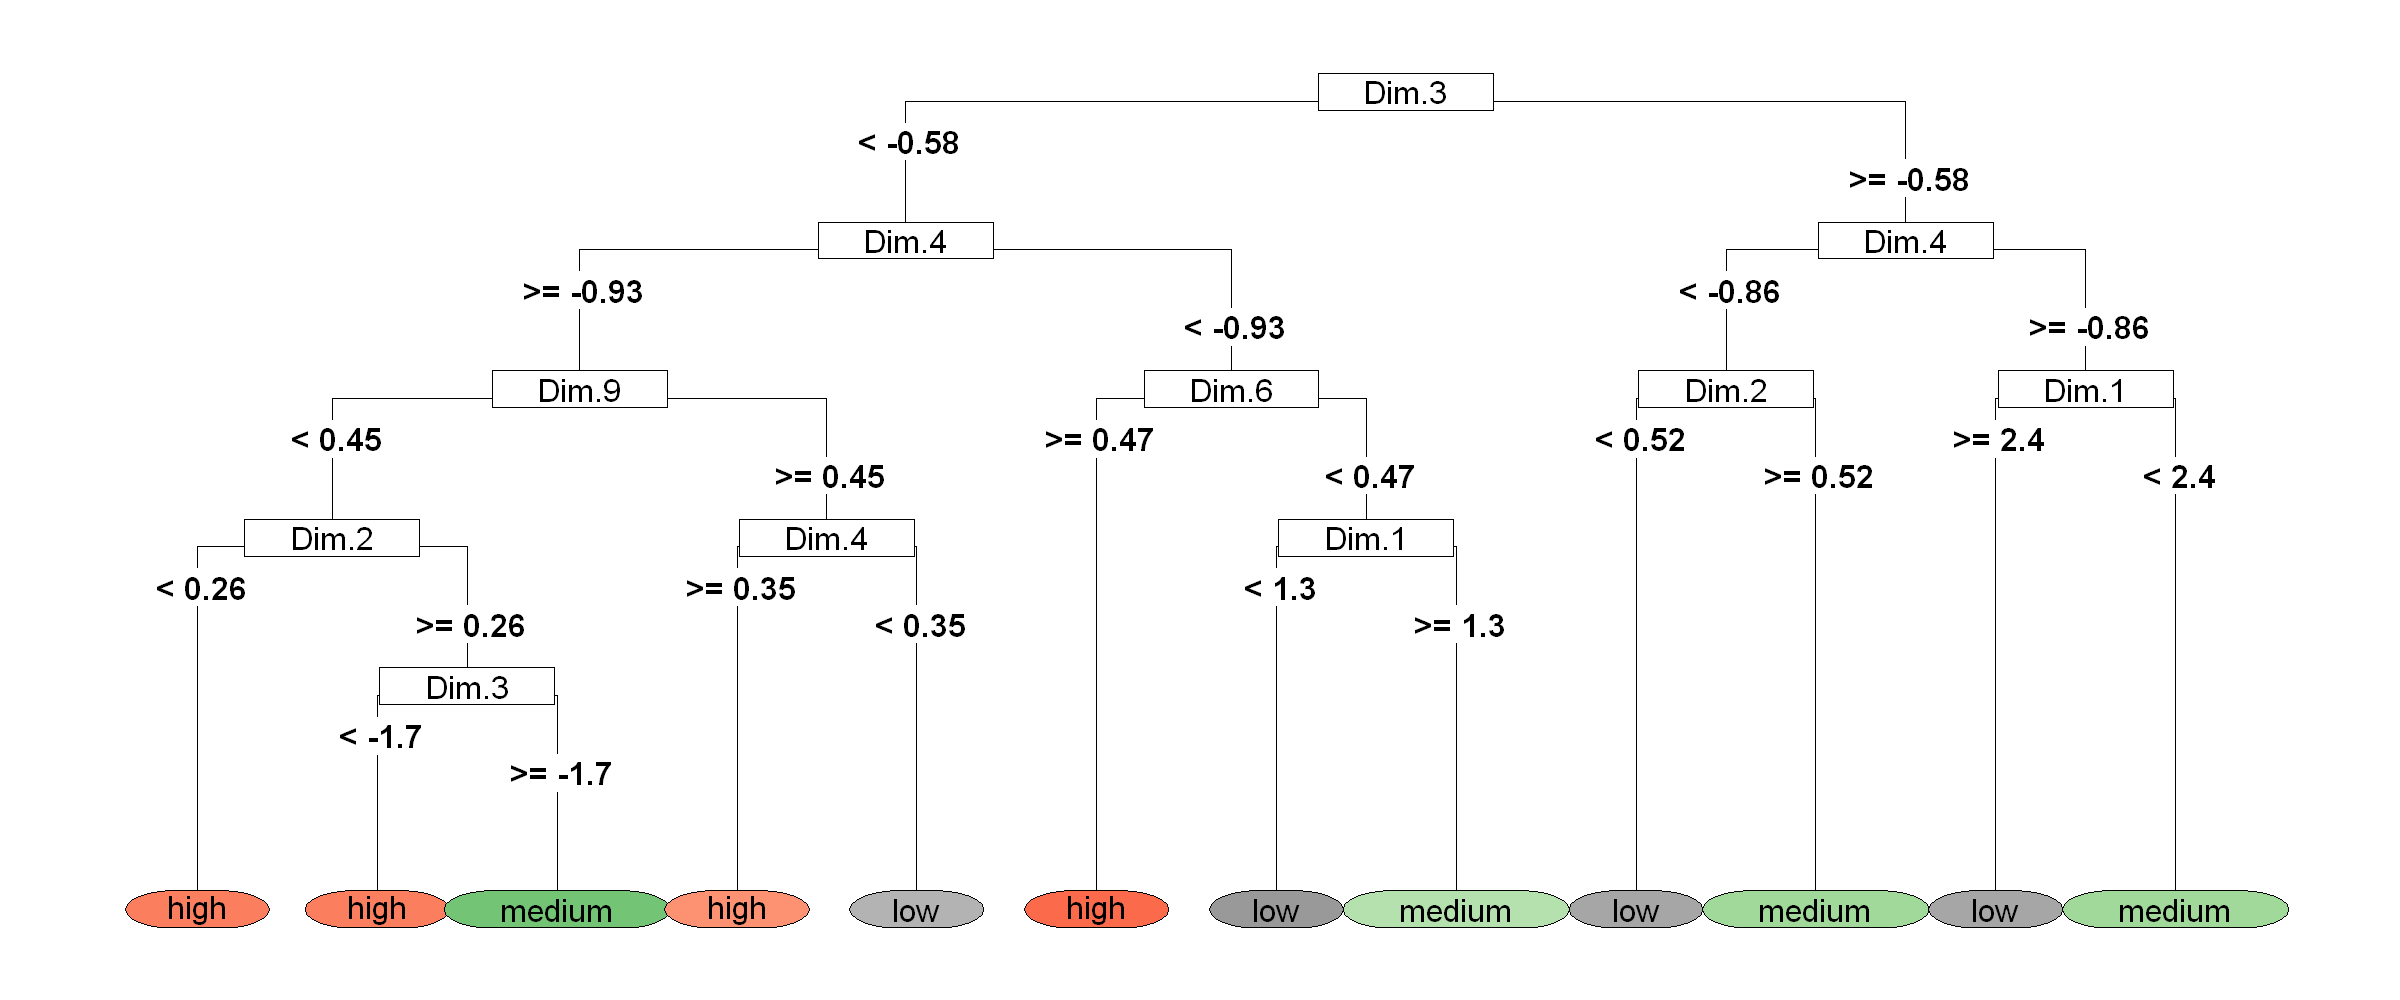

In [171]:
CART_model = rpart(quality ~ ., train_dat)
options(repr.plot.width = 12, rep.plot.height = 7, repr.plot.res = 200, err=-1)
rpart.plot(CART_model, extra = 0, type=5, tweak=1.2, legend.x=NULL, legend.y= NULL)

#### Đánh giá mô hình

In [172]:
# Predict fraud classe with SMOTE sampling
print("The test data")
summary(test_dat$quality)
print("Prediction")
predicted = predict(CART_model, test_dat, type = 'class')
summary(predicted)

[1] "The test data"


high    low medium 
   111     25    503

[1] "Prediction"


high    low medium 
   169     75    395

In [173]:
confusionMatrix(predicted,test_dat$quality)

Confusion Matrix and Statistics

          Reference
Prediction high low medium
    high     60   1    108
    low       5  10     60
    medium   46  14    335

Overall Statistics
                                          
               Accuracy : 0.6338          
                 95% CI : (0.5951, 0.6712)
    No Information Rate : 0.7872          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2089          
                                          
 Mcnemar's Test P-Value : 3.766e-12       

Statistics by Class:

                     Class: high Class: low Class: medium
Sensitivity               0.5405    0.40000        0.6660
Specificity               0.7936    0.89414        0.5588
Pos Pred Value            0.3550    0.13333        0.8481
Neg Pred Value            0.8915    0.97340        0.3115
Prevalence                0.1737    0.03912        0.7872
Detection Rate            0.0939    0.01565        0.5243
Det

#### Nhận xét mô hình đánh giá chất lượng rượu
Theo như kết quả dự đoán thì ta thấy rằng model máy học trên dự đoán đúng 405/639 tổng số các trường hợp. Điểm số của mô hình máy học này là 63.38%. Trong đó, các trường hợp dự đoán sai như sau:
- Tổng 111 trường hợp thuộc nhóm chất lượng cao, dự đoán đúng 60 trường hợp, 5 trường hợp dự đoán là chất lượng thấp và 46 trường hợp dự đoán là chết lượng trung bình.
- Tổng 503 trường hợp thuộc nhóm chất lượng trung bình, dự đoán đúng 335 trường hợp, có 108 trường hợp dự đoán nhầm lẫn sang nhóm chất lượng cao và 60 trường hợp nhầm sang nhóm chất lượng thấp.
- Tổng 25 trường hợp thuộc nhóm chất lượng thấp, dự đoán đúng 10 trường hợp, 14 trường hợp nhầm lẫn sang nhóm chất lượng trung bình và 1 trường hợp nhầm lẫn sang chất lượng cao.

Từ đó ta thấy rằng có 6/639 tổng số trường hợp dự đoán sai nghiêm trọng (nhỏ hơn 1%), tức là chất lượng thấp nhưng lại đoán là chất lượng cao, chất lượng cao nhưng lại dự đoán là chất lượng thấp.

### 4.2. Xây dựng mô hình máy học dự đoán loại rượu

Tương tự như trên ta tiến hành xây dựng mô hình dự đoán loại rượu vang

In [165]:
mydat = data.frame(cbind(res.pca$ind$coord[,1:5],type=wine_dat$type))
mydat[mydat$type == 2,'type'] <- 'white'
mydat[mydat$type == 1,'type'] <- 'red'
mydat$type <- as.factor(mydat$type)
head(mydat)

,Dim.1,Dim.2,Dim.3,Dim.4,Dim.5,type
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,-1.1583155,2.50205297,0.2217197,1.26054836,0.03139377,white
2,-0.8394453,-1.23367395,-1.4868028,-0.59027497,-0.70410815,white
3,-0.8165065,-0.02031042,1.2824748,-1.41618571,-0.03556543,white
4,-3.3597111,0.70299773,-0.5510811,0.01412896,-0.26905030,white
5,-2.1528084,0.60018393,-0.5024772,-0.64938786,0.48874428,white
6,-2.8004525,2.84244601,0.3240747,-0.16091926,0.27056494,white


Tách biệt hai tập dữ liệu để training và testing cho model máy học

In [141]:
set.seed(1)
dat_smpl = sample.split(mydat$type,SplitRat=0.8)
train_dat = data.frame(subset(mydat,dat_smpl == T))
test_dat = data.frame(subset(mydat,dat_smpl == F))
train_dat$type <- as.factor(train_dat$type)
test_dat$type <- as.factor(test_dat$type)
summary(train_dat$type)

red white 
 1279  1279

Xây dựng CART Model

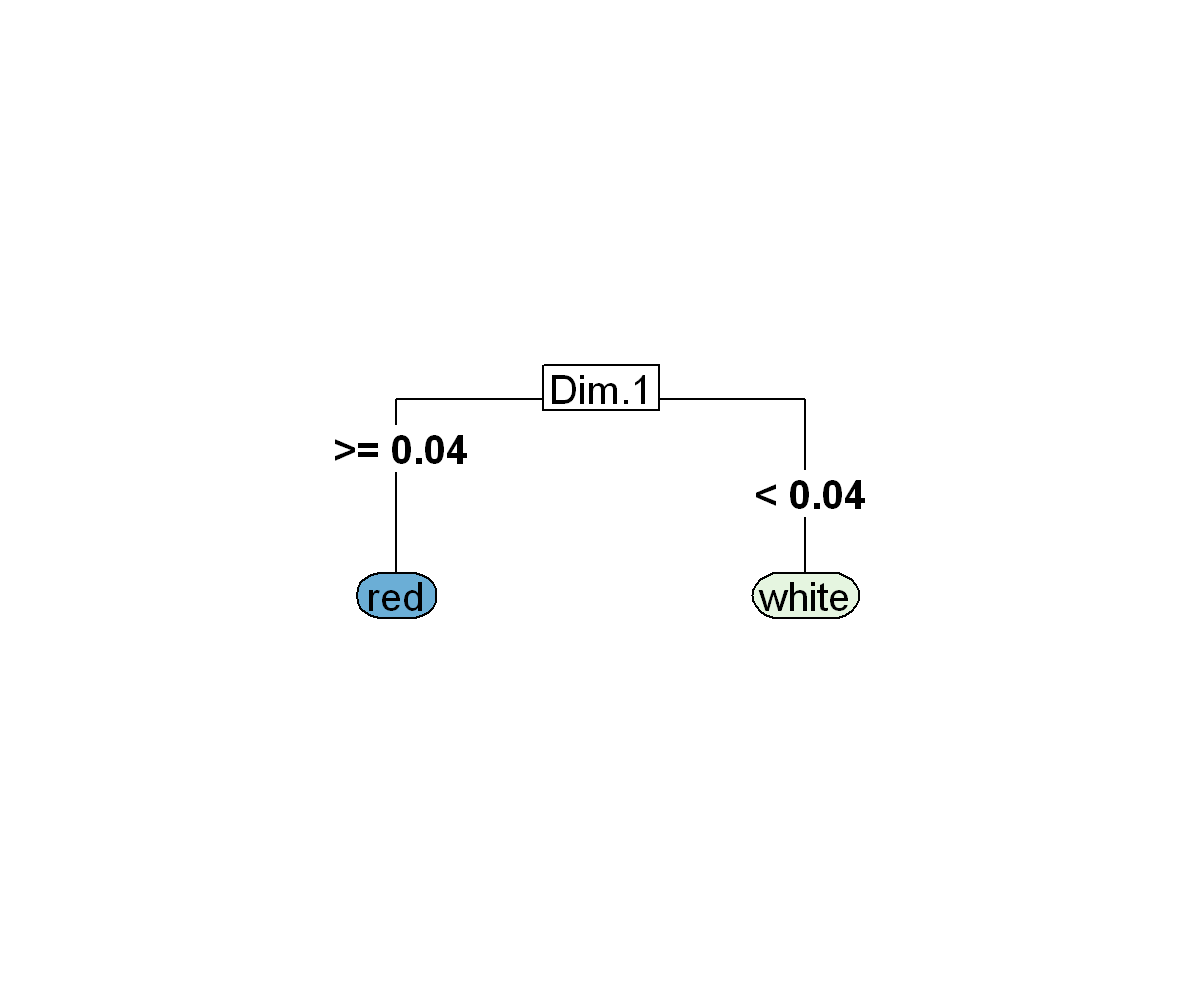

In [142]:
CART_model = rpart(type ~ ., train_dat)
options(repr.plot.width = 6, rep.plot.height = 6, repr.plot.res = 200)
rpart.plot(CART_model, extra = 0, type=5, tweak=1.2)

#### Đánh giá chất lượng mô hình

In [223]:
# Predict fraud classe with SMOTE sampling
print("The test data")
summary(test_dat$type)
print("Prediction")
predicted = predict(CART_model, test_dat, type = 'class')
summary(predicted)

[1] "The test data"


red white 
  320   320

[1] "Prediction"


red white 
  319   321

In [224]:
confusionMatrix(predicted,test_dat$type)

Confusion Matrix and Statistics

          Reference
Prediction red white
     red   314     5
     white   6   315
                                          
               Accuracy : 0.9828          
                 95% CI : (0.9695, 0.9914)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9656          
                                          
 Mcnemar's Test P-Value : 1               
                                          
            Sensitivity : 0.9812          
            Specificity : 0.9844          
         Pos Pred Value : 0.9843          
         Neg Pred Value : 0.9813          
             Prevalence : 0.5000          
         Detection Rate : 0.4906          
   Detection Prevalence : 0.4984          
      Balanced Accuracy : 0.9828          
                                          
       'Positive' Class : red             
                        

Từ trên cho thấy kết quả thực tế của tập dữ liệu testing thì có 320 trường hợp là rượu vang đỏ và 320 trường hợp là rượu vang trắng. Sau đó sẽ đem đi tiến hành dự đoán kết quả. Theo như kết quả dự đoán thì ta thấy rằng model máy học trên dự đoán đúng 314/320 trường hợp rượu vang đỏ dựa trên thành phần lý hóa và dự đoán đúng được 315/320 trường hợp rượu vang trắng. Tỷ lệ chính xác của model theo kết quả trên là 98.28%.

## 5. Kết luận

Như vậy qua kết quả phân tích và đánh giá ta có thể rút ra được những kết luận sau đây:

- Các thành phần hóa lý theo thống kê ta nhận thấy chỉ có thể giải thích hay dự đoán được một phần chất lượng của loại rượu, cụ thể theo như phân tích trong bài này tỉ lệ dự đoán chính xác chỉ khoảng 63.38% và kết quả này chỉ giải thích được 89.52% các giao động của dữ liệu. Trên thực tế nguyên liệu, các thành phần hóa lý của rượu chỉ đóng góp một phần trong việc làm tăng hương vị của rượu, ngoài ra yếu tố quan trọng khác nữa để khiến rượu ngon có thể là do phương pháp ủ rượu và môi trường ủ rượu.

- Đối với việc phân loại rượu vang thì hoàn toàn có thể giải thích hay dự đoán được loại rượu dự trên các thông số hóa lý của rượu theo như kết quả phân tích thành phần chính thì thành phần đầu tiên là thành phần giải thích gần như hoàn toàn cho việc phân loại rượu.